# Data Analysis

Initial investigation of open datasets provided by Edmonton Open Data. Main processes for analysis are trial and error ensuring optimized datatypes and spot checking missing values, both within the dataset and through mapping tools like Google Maps.

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# [Property Assessment Data 2018](https://data.edmonton.ca/City-Administration/Property-Assessment-Data-Current-Calendar-Year-/q7d6-ambg)

In [2]:
# set column names that are intuitive and callable attributes of the DataFrame
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']

# set datatypes for csv import to the DataFrame
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}

# set the order of columns
col_keep = ['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
             'garage', 'lat', 'long']

# import csv to DataFrame: df
df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# [Property Information Data 2018](https://data.edmonton.ca/City-Administration/Property-Information-Data-Current-Calendar-Year-/dkk9-cj3x)

In [3]:
# set column names that are intuitive, standardized, and callable attributes of the DataFrame
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']

# set datatypes for csv import to the DataFrame
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}

# set the order of columns
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

# import csv to DataFrame: df_info
df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

# Missing Value Analysis

Even though the 

In [4]:
df_null = df[df.nb.isnull()]
df_cleaned = df[~df.nb.isnull()]

print('The number of null neighbourhood records in df = {}'.format(len(df_null)))

The number of null neighbourhood records in df = 1


In [5]:
df_info_null = df_info[df_info.nb.isnull()]
df_info_cleaned = df_info[~df_info.nb.isnull()]

print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df_info = 1


In [40]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

In [ ]:
df_street_null = df_clean[df_clean.street.isnull()]
df_clean = df_clean[~df_clean.street.isnull()]

print('The number of null street records in df_clean = {}'.format(len(df_street_null)))

In [ ]:
df_clean['zoning'] = df_clean['zoning'].fillna('')

df_index = df_clean.zoning.str.contains('R')
df_clean = df_clean[df_index]

df_clean = df_clean[df_clean['class'] == 'Residential']

df_clean = df_clean[df_clean['value'].between(20000,2000000)]

In [7]:
df_grouped = df_clean.groupby(['nb']).mean()
df_grouped = df_grouped[['value']]

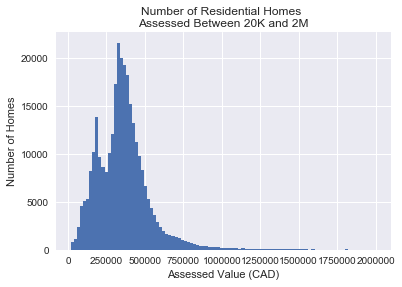

In [8]:
sns.set()
# Generate a plot of residential homes and minimize outliers.
ax = df_clean['value'].plot(kind='hist', bins=100, title='Number of Residential Homes \nAssessed Between 20K and 2M')
ax.set_xlabel('Assessed Value (CAD)')
ax.set_ylabel('Number of Homes')

plt.show()

In [9]:
%run stats_func.py

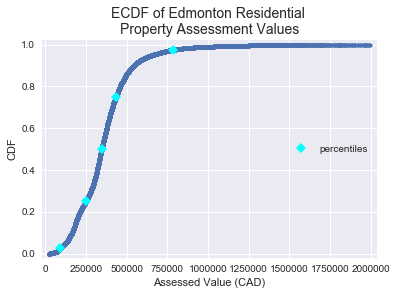

In [25]:
value = df_clean['value']
x, y = ecdf(value)

# Specify array of percentiles: percentiles
percentiles = np.array([2.5, 25, 50, 75, 97.5])

# Compute percentiles
ptiles = np.percentile(value, percentiles)

_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Assessed Value (CAD)')
_ = plt.ylabel('CDF')
_ = plt.title('ECDF of Edmonton Residential \nProperty Assessment Values', fontsize=14)

_ = plt.plot(ptiles, percentiles/100, marker='D', color='cyan', linestyle='none', label='percentiles')
_ = plt.legend(loc='center right')

plt.margins(0.02)

plt.show()

# EPS Neighbourhood Criminal Incidents 2018

In [26]:
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

df_crim = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

In [28]:
datetime = pd.to_datetime(df_crim['year'] + '-' + df_crim['month'])

df_crim['record_month'] = datetime

In [30]:
df_crim_clean = df_crim[['nb', 'violation', 'num_incidents', 'record_month']]

In [32]:
nb_incidents = df_crim.pivot_table(index='nb', values='num_incidents', 
                                   columns='violation', aggfunc='sum', fill_value=0)

neighbourhood_assess = df_grouped.merge(nb_incidents, left_on='nb', right_index=True)

nb_assess = neighbourhood_assess.reset_index()

In [33]:
def incident_dist(incident, high_count):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    low_count - is an int that represents the lowest incident count for a neighbourhood
    high_count - is an int that represents the lowest incident count for a neighbourhood
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhoods with no ' + incident + ' is/are: \n' 
          + str(nb_assess[nb_assess[incident] == 0].nb))
    print('\nThe neighbourhood with the most ' + incident + ' is: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,high_count), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents from 2009-18')
plt.show()

The maximum number of Theft Of Vehicle for any neighbourhood in Edmonton is: 
959

The neighbourhoods with no Theft Of Vehicle is/are: 
11         ANTHONY HENDAY CLAREVIEW
14     ANTHONY HENDAY LAKE DISTRICT
24                            ASTER
45            BLACKMUD CREEK RAVINE
229         MILL CREEK RAVINE SOUTH
279       RIVER VALLEY CAPITOL HILL
366     WHITEMUD CREEK RAVINE SOUTH
370                 WINDERMERE AREA
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]

The neighbourhood with the most Theft Of Vehicle is: 
104    DOWNTOWN
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


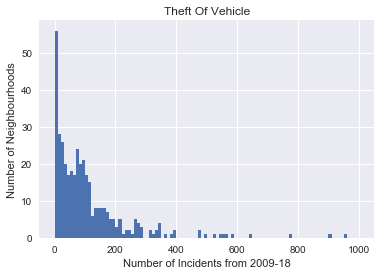

In [34]:
incident_dist('Theft Of Vehicle',1000)

In [36]:
%run keys.py

In [37]:
property2018 = client.get("3pdp-qp95")
property2018_detail = client.get("tu7d-8rsy")

In [38]:
property2018_df = pd.DataFrame.from_records(property2018)
property2018_detail_df = pd.DataFrame.from_records(property2018_detail)

In [39]:
from datetime import datetime

results_list = []
offset = 0
limit = 2000

start = datetime.now()
while True:
    print("Offset: {}".format(offset))
    results = client.get("aph8-rdbr", limit=limit, offset=offset)
    if len(results) == 0:
        print("No records found")
        break
    else:
        results_list+= results
        offset += limit

end = datetime.now()

print("Total time in minutes {}".format((end - start).total_seconds() // 60))

Offset: 0
Offset: 2000
Offset: 4000
Offset: 6000
Offset: 8000
Offset: 10000
Offset: 12000
Offset: 14000
Offset: 16000
Offset: 18000
Offset: 20000
Offset: 22000
Offset: 24000
Offset: 26000
Offset: 28000
Offset: 30000
Offset: 32000
Offset: 34000
Offset: 36000
Offset: 38000
Offset: 40000
Offset: 42000
Offset: 44000
Offset: 46000
Offset: 48000
Offset: 50000
Offset: 52000
Offset: 54000
Offset: 56000
Offset: 58000
Offset: 60000
Offset: 62000
Offset: 64000
Offset: 66000
Offset: 68000
Offset: 70000
Offset: 72000
Offset: 74000
Offset: 76000
Offset: 78000
Offset: 80000
Offset: 82000
Offset: 84000
Offset: 86000
Offset: 88000
Offset: 90000
Offset: 92000
Offset: 94000
Offset: 96000
Offset: 98000
Offset: 100000
Offset: 102000
Offset: 104000
Offset: 106000
Offset: 108000
Offset: 110000
Offset: 112000
Offset: 114000
Offset: 116000
Offset: 118000
Offset: 120000
Offset: 122000
Offset: 124000
Offset: 126000
Offset: 128000
Offset: 130000
Offset: 132000
Offset: 134000
Offset: 136000
Offset: 138000
Offset: 

Offset: 1094000
Offset: 1096000
Offset: 1098000
Offset: 1100000
Offset: 1102000
Offset: 1104000
Offset: 1106000
Offset: 1108000
Offset: 1110000
Offset: 1112000
Offset: 1114000
Offset: 1116000
Offset: 1118000
Offset: 1120000
Offset: 1122000
Offset: 1124000
Offset: 1126000
Offset: 1128000
Offset: 1130000
Offset: 1132000
Offset: 1134000
Offset: 1136000
Offset: 1138000
Offset: 1140000
Offset: 1142000
Offset: 1144000
Offset: 1146000
Offset: 1148000
Offset: 1150000
Offset: 1152000
Offset: 1154000
Offset: 1156000
Offset: 1158000
Offset: 1160000
Offset: 1162000
Offset: 1164000
Offset: 1166000
Offset: 1168000
Offset: 1170000
Offset: 1172000
Offset: 1174000
Offset: 1176000
Offset: 1178000
Offset: 1180000
Offset: 1182000
Offset: 1184000
Offset: 1186000
Offset: 1188000
Offset: 1190000
Offset: 1192000
Offset: 1194000
Offset: 1196000
Offset: 1198000
Offset: 1200000
Offset: 1202000
Offset: 1204000
Offset: 1206000
Offset: 1208000
Offset: 1210000
Offset: 1212000
Offset: 1214000
Offset: 1216000
Offset: 

Offset: 2120000
Offset: 2122000
Offset: 2124000
Offset: 2126000
Offset: 2128000
Offset: 2130000
Offset: 2132000
Offset: 2134000
Offset: 2136000
Offset: 2138000
Offset: 2140000
Offset: 2142000
Offset: 2144000
Offset: 2146000
Offset: 2148000
Offset: 2150000
Offset: 2152000
Offset: 2154000
Offset: 2156000
Offset: 2158000
Offset: 2160000
Offset: 2162000
Offset: 2164000
Offset: 2166000
Offset: 2168000
Offset: 2170000
Offset: 2172000
Offset: 2174000
Offset: 2176000
Offset: 2178000
No records found
Total time in minutes 16.0
